In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
class Passenger():

    def __init__(self, start, end, name):
        # variables describing the state of the passenger
        self.current = start
        self.end = end
        self.reached = self.current == self.end
        self.direction = self.determine_direction()
        self.name = name

    def determine_direction(self):
      # direction is True if passenger needs to go up,
      # False if needs to go down
        if self.end > self.current:
            return True
        else:
            return False

    def move_floor(self, direction):
        # change their floor when moving up or down
        # (first strategy)
        if direction:
            self.current += 1
        else:
            self.current -= 1
        # update whether the goal is reached
        self.reached = self.current == self.end

    def move_to_floor(self, floor):
      # move to a given floor when moving up or down
      # (second strategy)
        self.current = floor
        self.reached = self.current == self.end

    def __str__(self):
        # define the str method
        return self.name

    def __repr__(self):
      # representation
        return self.name

In [0]:
class Elevator():
    #describing the elevator class
    def __init__(self, location = 0, direction = True, passengers = None, capacity = 6):
        self.location = location
        self.direction = direction
        self.passengers = self.initialize_passengers(passengers)
        self.capacity = capacity
        self.step = 0
    
    def initialize_passengers(self, passengers):
        if passengers == None:
            return []
        else:
            return passengers

    # method for moving an elevator a single floor up or down 
    # depending on the direction
    def move_floor(self):
        self.step += 1
        if self.direction:
            self.location += 1
        else:
            self.location -= 1
        # when the elevator moves a floor, so do all the passengers in it
        for passenger in self.passengers:
              passenger.move_floor(self.direction)

    # method for directly moving the elevator to a given floor
    # rather than going in increments of 1
    def move_to_floor(self, goal):
        if goal != None:
          self.step += abs(goal - self.location)
          # takes a goal floor and moves to that floor
          # change the direction if necessary:
          if goal < self.location and self.direction:
              self.direction = False
          elif goal > self.location and not self.direction:
              self.direction = True
          # move to the floor
          self.location = goal
          for passenger in self.passengers:
              passenger.move_to_floor(goal)

    # method to change elevator's direction
    def change_direction(self):
        if self.direction:
            self.direction = False
        else:
            self.direction = True
    
    # method to load and unload passengers
    def load_passengers(self, building):
        self.step += 3
        #Check if anyone wants to get off
        for person in self.passengers:
            if person.reached:
                # remove from the elevator, add to the floor
                building.add_passenger(self.location,person)
                self.passengers.remove(person)
                # 1 open space left
                self.capacity +=1

        # check if there is capacity and if anyone wants to get on
        if self.capacity > 0:
            for person in building.floor_lists[self.location]:
                if self.capacity > 0:
                    if person.direction == self.direction and not person.reached:
                        # remove from the floor, add to the elevator
                        self.passengers.append(person)
                        building.remove_passenger(self.location,person)
                        self.capacity -= 1

    # method to find the next floor to visit 
    def next_floor(self, building):
        # In cases where elevator is going up:
        if self.direction == True:
            # Case 1: if there are people going up 
            # (either in elevator or to be picked up)
            going_up = []
            for person in self.passengers:
                if person.end > self.location:
                    going_up.append(person.end)
            for x in range(self.location + 1, building.n_floors):
                if any(person.direction == self.direction and not person.reached for person in building.floor_lists[x]):
                    going_up.append(x)
            # pick the closest one if the list is not empty
            if going_up != []:
                return min(going_up)

            # Case 2: people upstairs (or on the same floor) are going down
            upstairs_going_down = []
            for x in range(self.location, building.n_floors):
                for person in building.floor_lists[x]:
                    if person.direction != self.direction and not person.reached:
                        upstairs_going_down.append(x)
            # pick the highest
            if upstairs_going_down != []:
                # turn around since the person will be going down
                self.direction = False
                return max(upstairs_going_down)

            # Case 3: there's no reason to go up
            # find the closest floor downstairs to drop off 
            # or the next floor where people need to be picked up going down
            going_down = []
            for person in self.passengers:
                if person.end < self.location:
                    going_down.append(person.end)
            for x in range(self.location + 1):
                for person in building.floor_lists[x]:
                    if person.direction != self.direction and not person.reached:
                        going_down.append(x)
            # pick the closest of the two
            if going_down != []:
                # turn around if you are picking someone up downstairs
                self.direction = False
                return max(going_down)
          
            # Case 4: there are only people going up that are downstairs
            else:
                cur = [person.current for floor in building.floor_lists for person in floor if not person.reached]
                if cur != []:
                  return max(cur)
            # pick up person at lowest floor

        # Same process if going down, but opposite
        if self.direction == False:
            # if there are people going down (either in elevator or to be picked up)
            going_down = []
            for person in self.passengers:
                if person.end < self.location:
                    going_down.append(person.end)
            for x in range(self.location):
                if any(person.direction == self.direction and not person.reached for person in building.floor_lists[x]):
                    going_down.append(x)
            # pick the closest one if the list is not empty
            if going_down != []:
                return max(going_down)

            # if there are people going up that are downstairs
            downstairs_going_up = []
            for x in range(self.location + 1):
                for person in building.floor_lists[x]:
                    if person.direction != self.direction and not person.reached:
                        downstairs_going_up.append(x)
            # pick the lowest one
            if downstairs_going_up != []:
                # turn around since the person will be going up
                self.direction = True
                return min(downstairs_going_up)

            # if there's no reason to go down
            # find the closest floor upstairs to drop off
            # or the next floor where people need to be picked up going up
            going_up = []
            for person in self.passengers:
                if person.end > self.location:
                    going_up.append(person.end)
            for x in range(self.location + 1, building.n_floors):
                for person in building.floor_lists[x]:
                    if person.direction != self.direction and not person.reached:
                        going_up.append(x)
            # pick the closest
            if going_up != []:
                # turn around since the person will be going up
                self.direction = True
                return min(going_up)
          
            # in case there's only people going down that are downstairs
            else:
                cur = [person.current for floor in building.floor_lists for person in floor if not person.reached]
                if cur != []:
                  return max(cur)
            # pick up person at highest floor


In [0]:
class Building():
    #defining building class based on PCW criteria
    def __init__(self, n_floors = 10, n_passengers = 100):
        self.n_floors = n_floors
        self.floor_lists = self.initialize_floorlists(n_passengers)
        self.n_reached = self.count_reached()

    def initialize_floorlists(self,n_passengers):
        # generate n random passengers and put them into their initial floors
        initial_positions = np.random.randint(self.n_floors,size = (n_passengers,2))
        initial_lists = [[] for i in range(self.n_floors)]
        for index,init in enumerate(initial_positions):
            initial_lists[init[0]].append(Passenger(init[0],init[1],str(index)))
        return initial_lists

    def count_reached(self):
        # count the number of passengers at their goal
        count = 0
        for floor in self.floor_lists:
            for person in floor:
                if person.reached:
                    count += 1
        return count

    # to add passenger to the floor - remove from elevator
    def add_passenger(self, location, person):
        self.floor_lists[location].append(person)
        if person.reached:
            self.n_reached += 1

    # to remove passengers from the floor
    def remove_passenger(self,location, person):
        self.floor_lists[location].remove(person)
        if person.reached:
            self.n_reached -= 1

In [0]:
# Basic algorithm from assigment instructions

building = Building(10,50)
elevator = Elevator()

# run this algorithm until everyone reaches their floor
def basic_method(building,elevator,n_passengers):
    # run this until all passengers have reached their destination
    # this line makes sure the initial position doesn't fulfill the requirements
    while building.n_reached != n_passengers:
        # display the steps taken and number of completed passengers aftr every step
        print("number of people reached: ",building.n_reached)
        print("Steps taken: ", elevator.step)
        # if the elevator is at an end point, turn around
        if elevator.direction and elevator.location == building.n_floors-1:
            elevator.change_direction()
        elif not elevator.direction and elevator.location == 0:
            elevator.change_direction()
        # otherwise, load passengers and move by one floor
        else:
            elevator.load_passengers(building)
            elevator.move_floor()
        # once everyone has arrived, complete the simulation
            if building.n_reached == n_passengers:
                print("number of people reached: ",building.n_reached)
                print("Steps taken: ", elevator.step)
                return "Everyone arrived!"

basic_method(building,elevator,50)

In [0]:
# this algorithm uses the next_floor method of the elevator class to skip over
# floors that don't need a pick-up or drop-off.
def advanced_method(building,elevator,n_passengers):
    # run while not all passengers have arrived
    while building.n_reached != n_passengers:
        # display the state of the simulation
        print("number of people reached: ",building.n_reached)
        print("Steps taken: ", elevator.step)
        # load and unload passengers and move to the appropriate floor
        elevator.load_passengers(building)
        elevator.move_to_floor(elevator.next_floor(building))
        #print(elevator.passengers, [person.end for person in elevator.passengers])
        #print(elevator.direction,[person.direction for person in building.floor_lists[elevator.location] if not person.reached])
        if building.n_reached == n_passengers:
            print("number of people reached: ",building.n_reached)
            print("Steps taken: ", elevator.step)
            return "Everyone arrived!"

# create a building and run the simulation
building = Building(10,50)
elevator = Elevator()
advanced_method(building,elevator, 50)

In [0]:
# Basic algorithm from assigment instructions

# run this algorithm until everyone reaches their floor
# this is the same as basic_method, just without the print statements
def basic_method_no_print(building,elevator,n_passengers):
    # run until everyone arrived
    while building.n_reached != n_passengers:
        # change direction as necessary
        if elevator.direction and elevator.location == building.n_floors-1:
            elevator.change_direction()
        elif not elevator.direction and elevator.location == 0:
            elevator.change_direction()
        # otherwise, load and move a floor
        else:
            elevator.load_passengers(building)
            elevator.move_floor()
            # finish the simulation
            if building.n_reached == n_passengers:
                return "Everyone arrived!"

In [0]:
# this algorithm uses the next_floor method of the elevator class to skip over
# floors that don't need a pick-up or drop-off.
def advanced_method_no_print(building,elevator,n_passengers):
    while building.n_reached != n_passengers:
        # load and unload passengers and move to the appropriate floor
        elevator.load_passengers(building)
        elevator.move_to_floor(elevator.next_floor(building))
        # finish the simulation if everyone arrived
        if building.n_reached == n_passengers:
            return "Everyone arrived!"

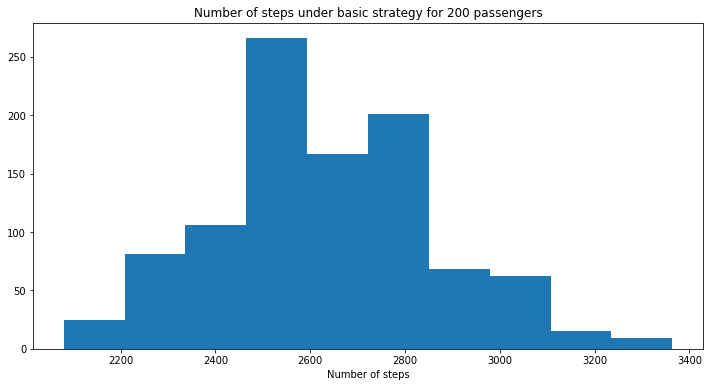

The mean number of steps is: 2629.888
The median number of steps is: 2620.0
The 95% confidence interval is from: 2254.8 to 3080.4999999999995


In [9]:
steps = []
passenger = 200

# run the simulation 1000 times and record the number of steps
for i in range(1000):
  building = Building(30, passenger)
  elevator = Elevator()
  basic_method_no_print(building,elevator, passenger)
  steps.append(elevator.step)

# plot the number of steps in a histogram
plt.figure(figsize= (12,6))
plt.hist(steps)
plt.title('Number of steps under basic strategy for 200 passengers')
plt.xlabel('Number of steps')
plt.show()
# find the mean, median and 95 interval
print("The mean number of steps is:", np.mean(steps))
print("The median number of steps is:", np.median(steps))
print("The 95% confidence interval is from:",np.quantile(steps,0.025),"to",np.quantile(steps,0.975))

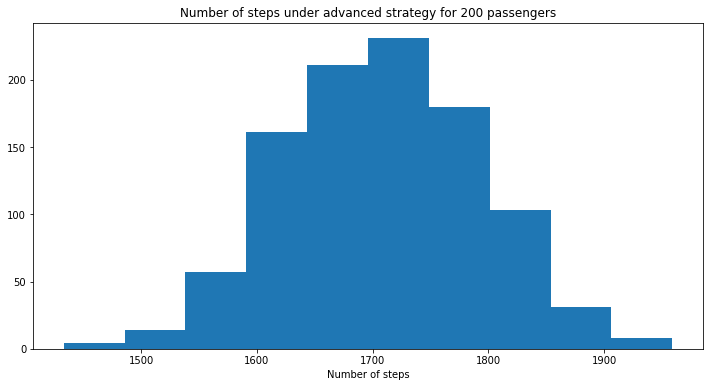

The mean number of steps is: 1707.85
The median number of steps is: 1708.0
The 95% confidence interval is from: 1554.9750000000001 to 1867.0500000000002


In [10]:
steps = []
passenger = 200

# run the simulation with the advanced method 1000 times
for i in range(1000):
  building = Building(30, passenger)
  elevator = Elevator()
  advanced_method_no_print(building,elevator, passenger)
  steps.append(elevator.step)

# plot a histogram of the number of steps taken
plt.figure(figsize= (12,6))
plt.hist(steps)
plt.title('Number of steps under advanced strategy for 200 passengers')
plt.xlabel('Number of steps')
plt.show()


# find the mean, median and 95 interval
print("The mean number of steps is:", np.mean(steps))
print("The median number of steps is:", np.median(steps))
print("The 95% confidence interval is from:",np.quantile(steps,0.025),"to",np.quantile(steps,0.975))

In [0]:
# variables to keep track of the advanced method
recorded_step_a = []
recorded_step_a_975 = []
recorded_step_a_025 = []

# variables to keep track of the basic method
recorded_step_b = []
recorded_step_b_975 = []
recorded_step_b_025 = []

# run the simulation for passenger numbers between 100 and 2000
for passenger in range(100, 2100, 100):
  steps = []
  # for every passenger number, run 100 times
  for i in range(100):
    building = Building(30, passenger)
    elevator = Elevator()
    advanced_method_no_print(building,elevator, passenger)
    steps.append(elevator.step)
  # add a datapoint about the average and 95% confidence interval
  recorded_step_a.append(np.mean(steps))
  recorded_step_a_975.append(np.quantile(steps, 0.975))
  recorded_step_a_025.append(np.quantile(steps, 0.025))

# do the same for the basic method
for passenger in range(100, 2100, 100):
  steps = []
  for i in range(100):
    building = Building(30, passenger)
    elevator = Elevator()
    basic_method_no_print(building,elevator, passenger)
    steps.append(elevator.step)
  # add a datapoint about the average and 95% confidence interval
  recorded_step_b.append(np.mean(steps))
  recorded_step_b_975.append(np.quantile(steps, 0.975))
  recorded_step_b_025.append(np.quantile(steps, 0.025))

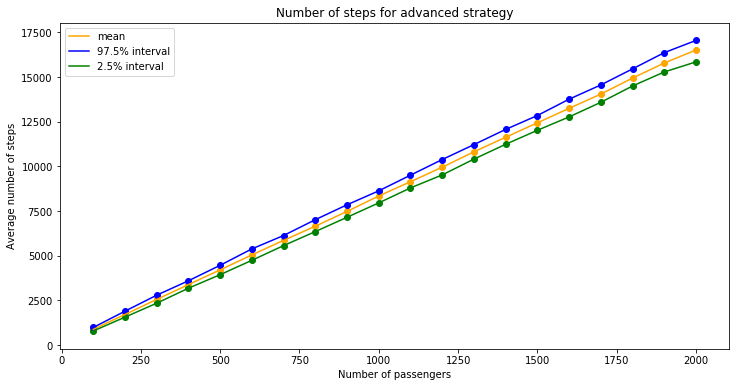

In [12]:
# plot all the findings on the same plot
plt.figure(figsize= (12,6))
plt.plot(range(100, 2100, 100), recorded_step_a, label = "mean", color = 'orange')
plt.plot(range(100, 2100, 100), recorded_step_a_975, label = "97.5% interval", color = 'blue')
plt.plot(range(100, 2100, 100), recorded_step_a_025, label = "2.5% interval", color = 'green')
plt.scatter(range(100, 2100, 100), recorded_step_a, color = 'orange')
plt.scatter(range(100, 2100, 100), recorded_step_a_025, color = 'green')
plt.scatter(range(100, 2100, 100), recorded_step_a_975, color = 'blue')
plt.legend()
plt.title('Number of steps for advanced strategy')
plt.xlabel('Number of passengers')
plt.ylabel('Average number of steps')
plt.show()

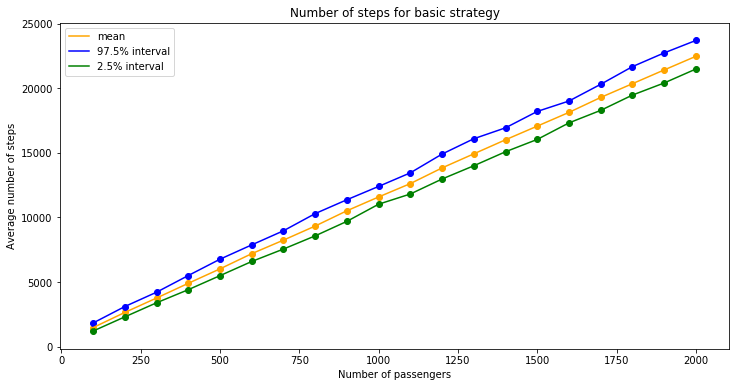

In [13]:

plt.figure(figsize= (12,6))
plt.plot(range(100, 2100, 100), recorded_step_b, label = "mean", color = 'orange')
plt.plot(range(100, 2100, 100), recorded_step_b_975, label = "97.5% interval", color = 'blue')
plt.plot(range(100, 2100, 100), recorded_step_b_025, label = "2.5% interval", color = 'green')
plt.scatter(range(100, 2100, 100), recorded_step_b, color = 'orange')
plt.scatter(range(100, 2100, 100), recorded_step_b_025, color = 'green')
plt.scatter(range(100, 2100, 100), recorded_step_b_975, color = 'blue')
plt.legend()
plt.title('Number of steps for basic strategy')
plt.xlabel('Number of passengers')
plt.ylabel('Average number of steps')
plt.show()

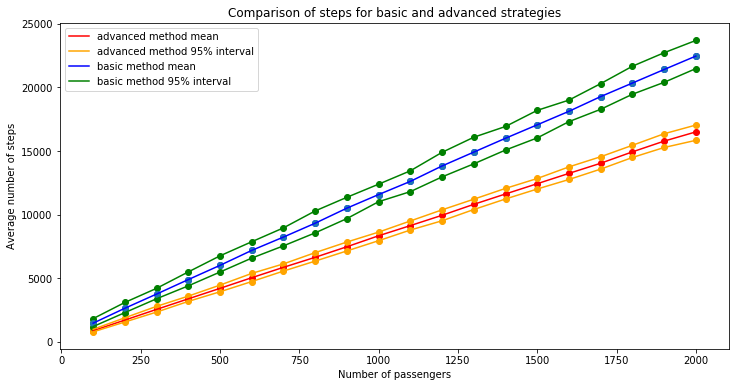

In [14]:
# compare the basic and advanced strategies

plt.figure(figsize= (12,6))

plt.plot(range(100, 2100, 100), recorded_step_a, label = "advanced method mean", color = 'red')
plt.plot(range(100, 2100, 100), recorded_step_a_975, label = "advanced method 95% interval", color = 'orange')
plt.plot(range(100, 2100, 100), recorded_step_a_025, color = 'orange')
plt.scatter(range(100, 2100, 100), recorded_step_a, color = 'red')
plt.scatter(range(100, 2100, 100), recorded_step_a_025, color = 'orange')
plt.scatter(range(100, 2100, 100), recorded_step_a_975, color = 'orange')

plt.plot(range(100, 2100, 100), recorded_step_b, label = "basic method mean", color = 'blue')
plt.plot(range(100, 2100, 100), recorded_step_b_975, label = "basic method 95% interval", color = 'green')
plt.plot(range(100, 2100, 100), recorded_step_b_025, color = 'green')
plt.scatter(range(100, 2100, 100), recorded_step_b, color = 'blue')
plt.scatter(range(100, 2100, 100), recorded_step_b_025, color = 'green')
plt.scatter(range(100, 2100, 100), recorded_step_b_975, color = 'green')
plt.scatter(range(100, 2100, 100), recorded_step_b)
plt.legend()
plt.title('Comparison of steps for basic and advanced strategies')
plt.xlabel("Number of passengers")
plt.ylabel("Average number of steps")
plt.show()